# Campaign Response Prediction - Performance Report

## Initializations

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ks_2samp

import xgboost as xgb
import lightgbm as lgb

import plotly.express as px
import plotly.graph_objects as go
from matplotlib.offsetbox import AnchoredText
    
import warnings
warnings.filterwarnings("ignore")

In [54]:
plt.rcParams.update({'font.family': ['Inter','sans-serif'], 'font.size' : 8 })
plt.rcParams.update({'figure.dpi' : 100})

## Load datasets

In [437]:
train_url = "https://raw.githubusercontent.com/tanatiem/campaign-response/main/datasets/train.csv"
test_url = "https://raw.githubusercontent.com/tanatiem/campaign-response/main/datasets/test.csv"

train_df = pd.read_csv(train_url, index_col=0)
test_df = pd.read_csv(test_url, index_col=0)

features = ['recency','frequency_2y','monetary_2y','length_of_stay',
                        'avg_spend_m_2y', 'avg_visit_m', 
                        'avg_tte_2y', 'std_tte',  'cv_tte', 
                        'std_ticket_size_2y', 'cv_ticket_size']

X_train = train_df.loc[:,features]
y_train = train_df['response']
X_test = test_df.loc[:,features]
y_test = test_df['response']

random_state = 61

## Helper Functions

In [438]:
class ModelProfile:
    def __init__(self, name, model, X, y):
        self.name = name
        self.model = model
        self.X = X
        self.y = y
        
        y_probas = model.predict_proba(X)
        self.y_score = y_probas[:,1]
        self.y_score_neg = y_probas[:,0]

        self.fpr, self.tpr, _ = roc_curve(self.y, self.y_score)
        self.auc = roc_auc_score(self.y, self.y_score)
        
        self.y_pred = model.predict(X)
        self.cm = confusion_matrix(self.y, self.y_pred)
        
        self.df = pd.DataFrame({'ground_truth' : self.y.values, 
                                'score' : self.y_score,
                                })
        self.decile_df = self.decile_dataframe()
        
    def decile_dataframe(self):
        df = self.df.copy()
        df['decile'] = pd.qcut(df.score, q=10, labels=np.arange(10,0,-1))
        data = df.groupby('decile', as_index=False).agg(n_event=('ground_truth','sum'), population=('score','count'))
        data = data.sort_values('decile', ascending=False)
        data['pct_event'] = data.n_event / data.n_event.sum() * 100
        data['cum_gain'] = data.pct_event.cumsum()
        data['cum_population'] = data.population.cumsum() / data.population.sum() * 100
        data['lift'] = data.cum_gain / data.cum_population
        return data

def plot_roc_curves(profiles, ax):
    
    for profile in profiles:
        ax.plot(profile.fpr, profile.tpr, label=f"{profile.name} AUC={round(profile.auc,4)}")
    ax.plot([0, 1], [0, 1], color='.8', lw=1.5, linestyle='--')
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    ax.grid(alpha=.3)#color='.8', linewidth=.5)
    return ax
        
def plot_score_dist(profile, ax):
    bins = np.arange(0.0, 1.01, 0.05)
    df = profile.df
    sns.histplot(x='score', data=df, hue='ground_truth', bins=bins, element='step', stat='percent', ax=ax, palette='Set2')
    ax.set_xticks(bins, minor=True)
    ax.set_xlabel('Prediction Score')
    ax.grid(which='major', alpha=.4)
    ax.grid(which='minor', alpha=.2)
    ax.legend(title='Ground Truth', loc='upper right', labels=['Class 1', 'Class 0'])
    ax.set_title('Score Distribution')
    return ax


def plot_ecdf(profile, ax):
    df = profile.df
    class0 = df[df['ground_truth'] == 0]
    class1 = df[df['ground_truth'] == 1]
    ks, pvalue = ks_2samp(class0['score'], class1['score'])
    ks_text = f"KS Statistics: {ks:.4}{'***' if pvalue < .01 else '**' if pvalue < .05 else '*' if pvalue < .1 else ''}"
    sns.ecdfplot(data=df, x='score', hue='ground_truth', ax=ax, palette='Set2')
    ax.set_xlim(0,1)
    at = AnchoredText(ks_text, pad=.5, frameon=True, loc='lower right')
    at.patch.set_edgecolor('.75')
    ax.add_artist(at)
    ax.legend(title='Ground Truth', loc='upper left', labels=['Class 1', 'Class 0'])
    ax.grid(True, alpha=.3)
    ax.set_title('CDF')
    return ax

def plot_lift_chart(profiles, ax, annot=False, legend=False):
    for profile in profiles:
        data = profile.decile_df
        ax.plot([1,10],[1,1], color='gray', linestyle='--', alpha=.6)
        ax.plot(data.decile, data.lift, marker='s', markersize=4, label=profile.name)
        if annot:
            for x,y in data[['decile','lift']].values[:-1]:
                ax.annotate(f"{y:.2f}", xy=(x,y), xytext=(5, 0), textcoords='offset points', ha='left', va='baseline')
    ax.grid(alpha=.25)
    if legend:
        ax.legend()
    ax.set_xlabel('Decile')
    ax.set_ylabel('Lift')
    ax.set_title('Lift Chart')
    return ax

def plot_cumulative_gain(profiles, ax, annot=False, legend=False):
    for profile in profiles:
        data = profile.decile_df
        x = [0] + data.decile.tolist()
        y = [0] + data.cum_gain.tolist()
        ax.plot([0,10],[0,100], color='gray', linestyle='--', alpha=.6)
        ax.plot(x, y, marker='s', markersize=4, label=profile.name)
        if annot: 
            for x,y in data[['decile','cum_gain']].values[:-2]:
                ax.annotate(f"{y:.1f}", xy=(x,y), xytext=(-3, -12), textcoords='offset points', ha='left', va='bottom')
    ax.grid(alpha=.25)
    if legend:
        ax.legend()
    ax.set_xlabel('Decile')
    ax.set_ylabel('% Respond')
    ax.set_title('Cumulative Gain')
    return ax

def plot_confusion_matrix(profile, ax):
    disp = ConfusionMatrixDisplay.from_estimator(
        profile.model, profile.X, profile.y,
        display_labels=['Not Respond','Respond'], cmap=plt.cm.Blues,
        normalize='all', ax=ax
    )
    disp.im_.colorbar.remove()
    ax.set_title('Normalized Confusion Matrix')
    return ax

def model_report(name, train_profile, test_profile):
    fig, axes = plt.subplots(2,3, figsize=(11,5.5), dpi=100, tight_layout=True)
    axes = axes.ravel()
    plot_roc_curves([train_profile, test_profile], ax=axes[0])
    plot_score_dist(test_profile, ax=axes[1])
    plot_ecdf(test_profile, ax=axes[2])
    plot_lift_chart([test_profile], ax=axes[3], annot=True)
    plot_cumulative_gain([test_profile], ax=axes[4], annot=True)
    plot_confusion_matrix(test_profile, ax=axes[5])
    fig.suptitle(name)
    

# Model Report

## Model #1 - XGBoost

In [442]:
xgb_params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'auc',
    'nthread' : -1,
    'scale_pos_weight' : 9.63127413127413,
    'random_state' : random_state,
    'use_label_encoder' : False,
    'tree_method' : 'approx',
    'max_depth': 2,
    'learning_rate': 0.3052892973378435,
    'subsample': 0.904774690566026,
    'colsample_bytree': 0.8628777267625374,
    'colsample_bylevel': 0.9177121992719132,
    'colsample_bynode': 0.11510608947124179,
    'reg_alpha': 6.378828307258065,
    'reg_lambda': 23.37553281678809,
    'gamma': 0.15216206659591713,
    'min_child_weight': 10,
    'n_estimators' : 20
}
model1 = xgb.XGBClassifier(**xgb_params)
model1 = model1.fit(X_train, y_train, verbose=False)

model1_train = ModelProfile('XGB-Train', model1, X_train, y_train)
model1_test = ModelProfile('XGB-Test', model1, X_test, y_test)

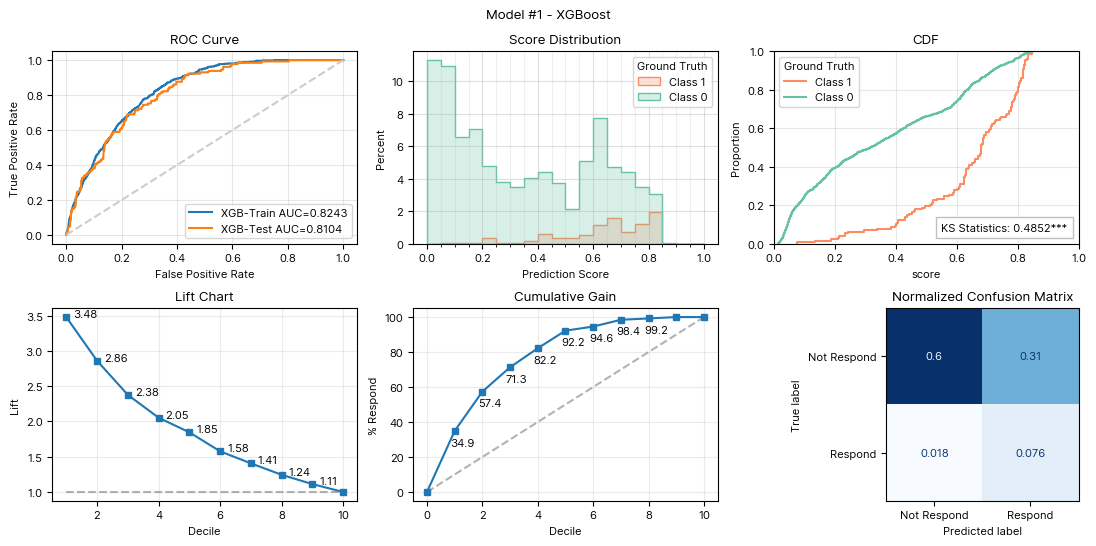

In [444]:
model_report('Model #1 - XGBoost', train_profile=model1_train, test_profile=model1_test)
plt.savefig('../images/model1_report.png', facecolor='white', transparent=False)
plt.show()

## Model #2 - LightGBM

In [445]:
lgb_params = {
    'objective' : 'binary',
    'is_unbalance' : 'true',
    'metric' : 'auc',
    'random_state' : random_state,
    'verbose' : -1,
    'learning_rate': 0.21806803702207628,
    'max_depth': 4,
    'num_leaves': 11,
    'min_data_in_leaf': 35,
    'min_gain_to_split': 7,
    'min_sum_hessian_in_leaf': 27,
    'feature_fraction': 0.8063544991027742,
    'bagging_fraction': 0.8988642857435954,
    'bagging_freq': 9,
    'lambda_l1': 6.943519706138764,
    'lambda_l2': 7.191475470590419,
    'n_estimators' : 14
}
model2 = lgb.LGBMClassifier(**lgb_params)
model2 = model2.fit(X_train, y_train, verbose=-1)

model2_train = ModelProfile('LGBM-Train', model2, X_train, y_train)
model2_test = ModelProfile('LGBM-Test', model2, X_test, y_test)

[LightGBM] [Warning] feature_fraction is set=0.8063544991027742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8063544991027742
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=7, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7
[LightGBM] [Warning] lambda_l1 is set=6.943519706138764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.943519706138764
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=27, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=27
[LightGBM] [Warning] bagging_fraction is set=0.8988642857435954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8988642857435954
[LightGBM] [Warning] lambda_l2 is set=7.191475470590419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.191475470590419
[LightGBM] [Warning] bagging_freq is set=9, subsample_fr

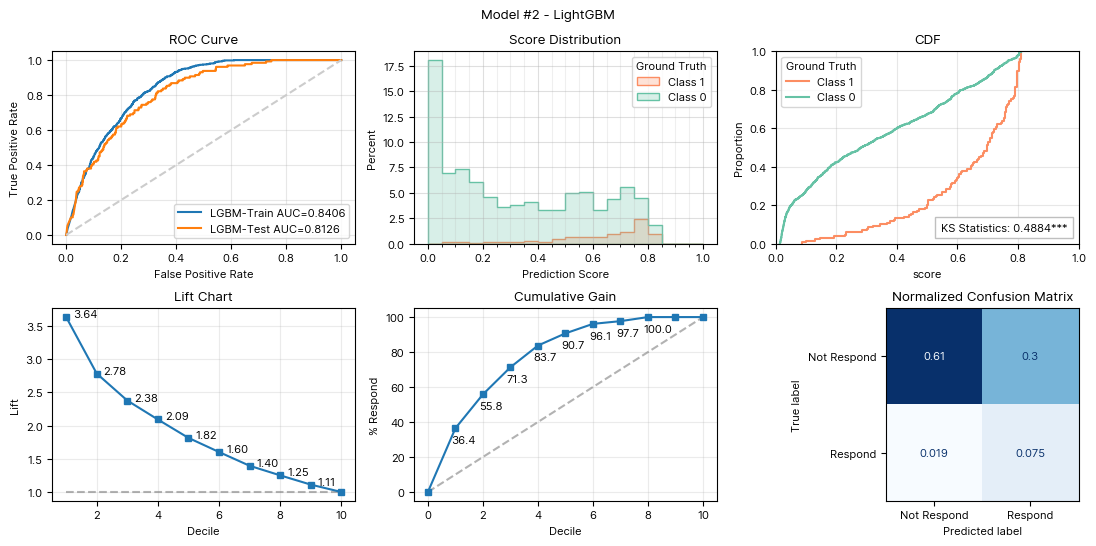

In [446]:
model_report('Model #2 - LightGBM', train_profile=model2_train, test_profile=model2_test)
plt.savefig('../images/model2_report.png', facecolor='white', transparent=False)
plt.show()

## Comparison

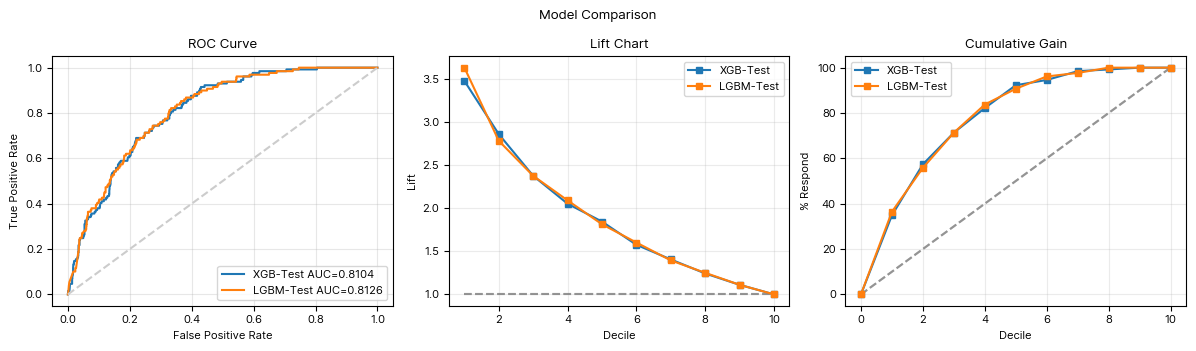

In [449]:
fig, axes = plt.subplots(1,3, figsize=(12,3.5), dpi=100, tight_layout=True)

profiles = [model1_test, model2_test]
plot_roc_curves(profiles, ax=axes[0])
plot_lift_chart(profiles, ax=axes[1], annot=False, legend=True)
plot_cumulative_gain(profiles, ax=axes[2], annot=False, legend=True)
fig.suptitle('Model Comparison')
plt.savefig('../images/model_comparison.png', facecolor='white', transparent=False)
plt.show()